## Принятие решений в бизнесе на основе данных

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

### Часть 1. Приоритизация гипотез

В файле `hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach, Impact, Confidence, Effort`.

In [2]:
hypotheses = pd.read_csv('/datasets/hypothesis.csv')
hypotheses

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


**Задача №1. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [3]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Efforts']
hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


**Задача №2. Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [4]:
hypotheses['RICE'] =  (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Efforts']
hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


**Вывод:** итак, рассмотрим полученные результаты. Фреймворк **ICE** отдал наибольший приоритет **гипотезе №8**, далее расположились гипотезы №0 и №7. Это связано с тем, что параметры `Impact` (влияние на пользователей) и `Confidence` (уверенность в гипотезе) имеют высокие коэффициенты при среднем `Effort` (затратах на проверку гипотезы). При добавлении параметра `Reach` (охват пользователей) в уверенные лидеры выбивается **гипотеза №7**, так как она предполагает максимальный охват пользователей. Далее расположились гипотезы №2 (у нее большой охват, но при этом низкий показатель влияния на пользователя) и №0. Гипотеза №8 сместилась на 5 позицию из-за очень низкого охвата.

### Часть 2. Анализ А/B-теста

**Задача: проанализировать A/B-тест**

**0. Посмотрим на данные для анализа.**

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Исследуем данные более тщательно. Рассмотрим таблицу заказов.

In [8]:
# исследуем данные более тщательно
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders['date'] = orders['date'].astype('datetime64')

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
orders.duplicated().sum()

0

In [12]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Исследуем таблицу visitors.

In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
visitors['date'] = visitors['date'].astype('datetime64')

In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [16]:
visitors.duplicated().sum()

0

In [17]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

**Вывод:** в результате был проведен первичный анализ данных. Были заменены типы у признаков с датами в таблицах *orders* и *visitors*. Дубликатов, пропусков и некорректных значений не обнаружено.

**1. Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.**

In [18]:
# создадим массив уникальных пар значений дат и групп 
datesGroup = orders[['date', 'group']].drop_duplicates()
datesGroup.head(6)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
66,2019-08-01,B


In [19]:
# созададим ordersAggragated, содержащую дату, группу, число уникальных заказов в группе теста по указанную дату,
# число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату,
# суммарную выручку заказов в группе теста по указанную дату
ordersAggregated = datesGroup.apply(
                                    lambda x: orders[np.logical_and(
                                                                    orders['date']<=x['date'],
                                                                    orders['group']==x['group'])]
                                                    .agg({
                                                            'date' : 'max',
                                                            'group' : 'max',
                                                            'transactionId' : pd.Series.nunique,
                                                            'visitorId' : pd.Series.nunique,
                                                            'revenue' : 'sum'}), axis=1)
ordersAggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-15,B,339,317,2367945
2,2019-08-15,A,283,259,1979057
45,2019-08-16,A,301,277,2078908
47,2019-08-16,B,359,336,2539635
55,2019-08-01,A,24,20,148579
...,...,...,...,...,...
1068,2019-08-12,A,230,210,1562873
1114,2019-08-13,B,285,268,1853738
1116,2019-08-13,A,244,223,1826511
1149,2019-08-14,B,308,287,2025446


In [20]:
# создадим переменную visitorsAggregated, содержащую 
# дату, группу A/B-теста, количество уникальных посетителей в группе теста по указанную дату включительно.
visitorsAggregated = datesGroup.apply(
                                         lambda x: visitors[np.logical_and(
                                                     visitors['date'] <= x['date'], 
                                                     visitors['group']==x['group'])]
                                        .agg({'date':'max', 'group':'max', 'visitors':'sum'}),axis=1)
visitorsAggregated

,date,group,visitors
0,2019-08-15,B,9600
2,2019-08-15,A,9686
45,2019-08-16,A,10047
47,2019-08-16,B,10013
55,2019-08-01,A,719
...,...,...,...
1068,2019-08-12,A,7575
1114,2019-08-13,B,8310
1116,2019-08-13,A,8323
1149,2019-08-14,B,9056


In [21]:
# отсортируем полученные таблицы по дате и группам
ordersAggregated = ordersAggregated.sort_values(by=['date', 'group']) 
visitorsAggregated = visitorsAggregated.sort_values(by=['date', 'group']) 

In [22]:
# объединим кумулятивные данные в одной таблице и переименуем столбцы 
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders_cnt', 'buyers_cnt', 'revenue', 'visitors_cnt']
cumulativeData.head()

,date,group,orders_cnt,buyers_cnt,revenue,visitors_cnt
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


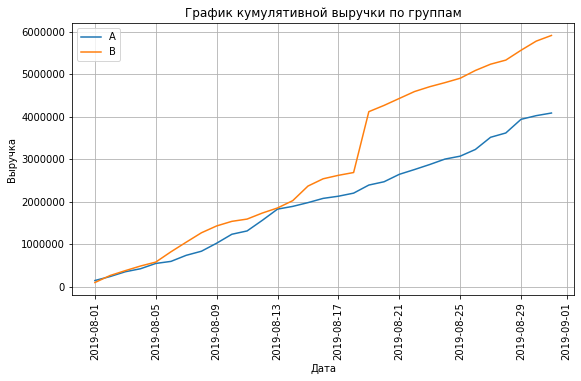

In [23]:
# срез с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders_cnt']]

# срез с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders_cnt']]

plt.figure(figsize=(9,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.legend() 
plt.show()

**Вывод:** заметим на графике, что кривая накопленной выручки группы B всегда находится выше кривой группы А. Причем, в определенный момент времени выручка группы В резко увеличивается. Этот факт может говорить о том, что возросло число заказов, либо появились очень дорогие заказы.

**2. Построим график кумулятивного среднего чека по группам. Сделайте выводы и предположения.**

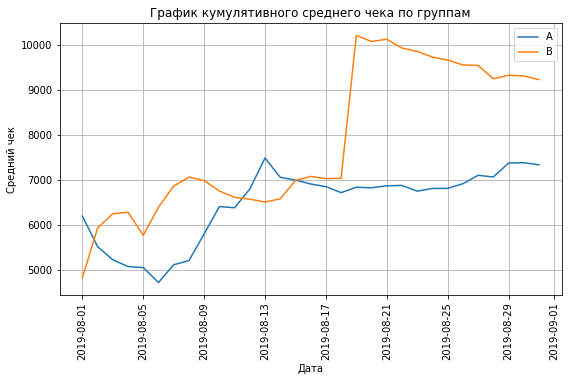

In [24]:
plt.figure(figsize=(9,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders_cnt'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders_cnt'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.grid(True)
plt.show()

**Вывод:** как видно по графику средний чек колеблется в разные дни. Если рассматривать группу А, то в начале месяца наблюдался спад, после чего был уверенный рост среднего чека, в определенный момент средний чек группы А даже превысил средний чек группы В, достигнув пика, после чего стал равномерным.\
Что касается группы В, то кривая среднего чека колеблется в первой половине месяца, после чего наблюдается резкий рост и далее постепенное снижение. Возможно, такой всплеск обуславливается наличием крупных заказов в данное время.

**3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.**

In [25]:
# соберем данные в одной таблице 
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,date,revenueA,orders_cntA,revenueB,orders_cntB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


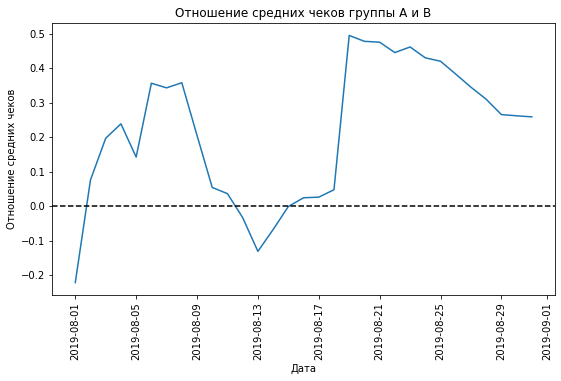

In [26]:
# cтроим отношение средних чеков
plt.figure(figsize=(9,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['orders_cntB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['orders_cntA'])-1)
plt.title('Отношение средних чеков группы А и В')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.xticks(rotation=90)
plt.show()

**Вывод:** как видно, на графике есть перепад, что также говорит о присутствии дорогих заказов. В целом, средний чек группы B больше, чем средний чек группы А.

**4. Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.**

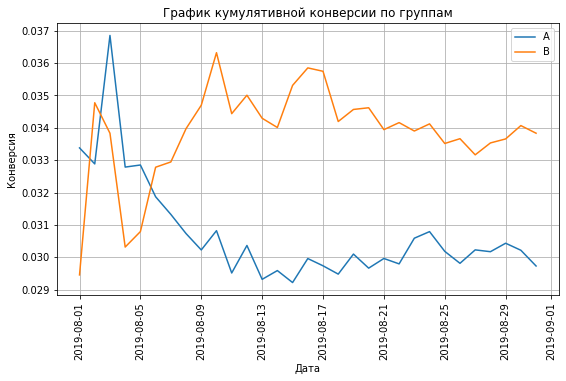

In [27]:
# найдем конверсию
cumulativeData['conversion'] = cumulativeData['orders_cnt'] / cumulativeData['visitors_cnt']

# сделаем срез для группы А и В
cumulativeConversionA = cumulativeData.query('group == "A"')[['date', 'conversion']]
cumulativeConversionB = cumulativeData.query('group == "B"')[['date', 'conversion']]

# построим графики кумулятивной конверсии
plt.figure(figsize=(9,5))
plt.plot(cumulativeConversionA['date'], cumulativeConversionA['conversion'], label='A')
plt.plot(cumulativeConversionB['date'], cumulativeConversionB['conversion'], label='B')

plt.xticks(rotation=90)
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** график показал, что в первую неделю конверсия обеих групп колебалась , после чего конверсия группы А пошла на спад и в последствии установилась около 0.03. Конверсия группы В наоборот пошла ввысь и затем зафиксировалась на отметке +-0.034.

**5. Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.**

In [28]:
# соединим таблицы в одну для удобства
mergedConversionData = cumulativeConversionA.merge(cumulativeConversionB, on='date', how='left', suffixes=['A', 'B'])
mergedConversionData.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


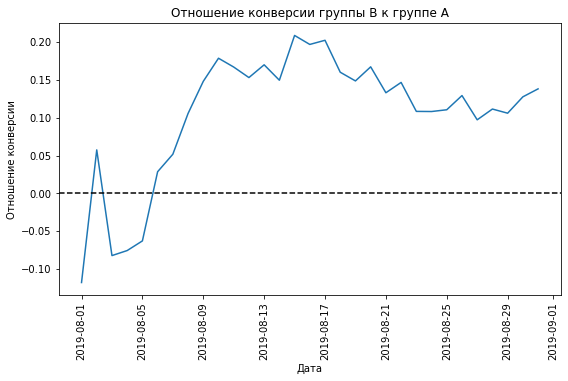

In [29]:
# построим график
plt.figure(figsize=(9, 5))
plt.plot(mergedConversionData['date'], mergedConversionData['conversionB'] / mergedConversionData['conversionA'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Отношение конверсии группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение конверсии')
plt.xticks(rotation=90)
plt.show()

**Вывод:** данный график отразил результаты предыдущего - в начале месяца присутствует колебание, затем показатели группы В значительно лучше, чем группы А. В целом, конверсия установилась. Однако, следует провести более тщательный анализ, например, исследовать аномалии. 

**6. Построим точечный график количества заказов по пользователям.**

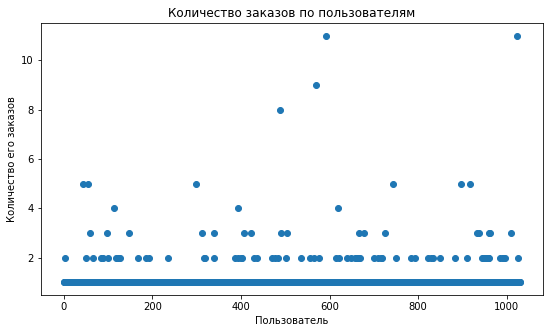

In [30]:
grouped = orders.groupby('visitorId').agg({'transactionId':'count'}).reset_index()
x_values = pd.Series(range(0, len(grouped['visitorId'])))
plt.figure(figsize=(9,5))
plt.scatter(x_values, grouped['transactionId'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователь')
plt.ylabel('Количество его заказов')
plt.show()

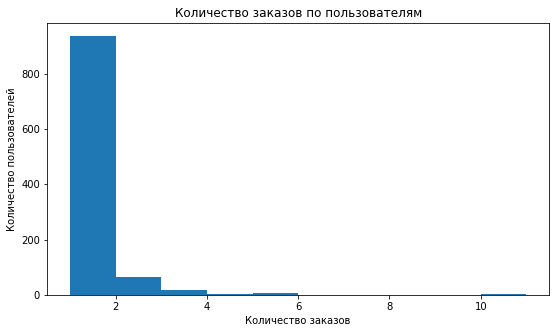

In [31]:
x_values = pd.Series(range(0, len(grouped['visitorId'])))
plt.figure(figsize=(9,5))
plt.hist(grouped['transactionId'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод:** графики показали, что есть пользователи, которые совершают аномальное количество заказов по сравнению с остальной выборкой. Есть пользователи, совершившые более 4 и даже более 8 заказов.

**7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.**

In [32]:
print(np.percentile(grouped['transactionId'], [95, 99]))

[2. 4.]


**Вывод:** 5% пользователей совершает более 2 заказов и 1% пользователей совершает более 4 заказов. На мой взгляд, в качестве границы для определения аномальных пользователей лучше выбрать значение 4, так как оно не сильно отбивается от 2 и можно допускать такое количество покупок пользователями.

**8. Построим точечный график стоимостей заказов.**

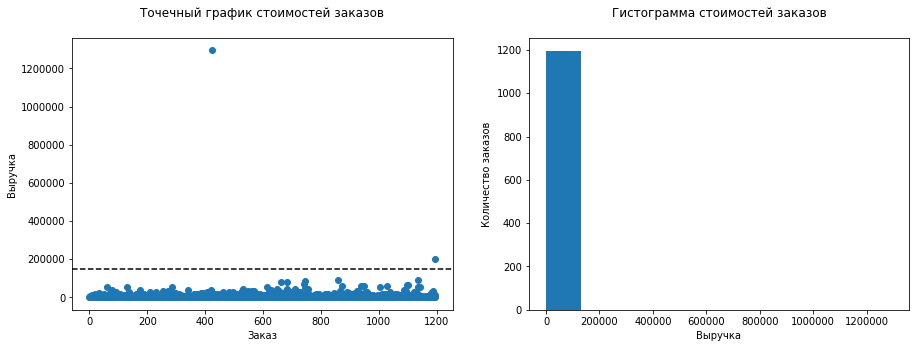

In [33]:
fg, ax = plt.subplots(1,2,figsize=(15,5))

x_values = pd.Series(range(0, len(orders['transactionId'])))
ax[0].scatter(x_values, orders['revenue'])
ax[0].axhline(y=150000, color='black', linestyle='--')
ax[0].set_title('Точечный график стоимостей заказов\n')
ax[0].set_xlabel('Заказ')
ax[0].set_ylabel('Выручка')
#plt.show()
ax[1].hist(orders['revenue'])
ax[1].set_title('Гистограмма стоимостей заказов\n')
ax[1].set_xlabel('Выручка')
ax[1].set_ylabel('Количество заказов')
plt.show()

In [34]:
orders[orders['revenue'] >= 150000]['revenue']

425     1294500
1196     202740
Name: revenue, dtype: int64

**Вывод:** как видим лишь два заказа превышают по стоимости 150 тыс.руб. Это заказы стоимость 202740 тыс.руб и очень дорогой заказ стоимостью 1,294 млн.руб. Такие заказы могут сказываться на данные о среднем чеке и выручке.

**9. Посчитаем 95-й и 99-й перцентили стоимости заказов.**

In [35]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**Вывод:** полученные результаты показали, что 5% пользователей совершает заказов на сумму больше 28000 и 1% пользователей превышает заказов на сумму больше 58233 рублей. В качестве границы для аномальных значений я решил принять значение в 58000 рублей.

**10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.**

Сформулируем нулевую и альтернативную гипотезы для проверки.\
**H0:** статистически значимое различие в конверсии между группами по "сырым данным отсутствует".\
**H1:** различие в конверсии между группами по "сырым данным" статистически значимо.

In [36]:
# посчитаем количество пользователей в выбранную дату в группах A и В
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# посчитаем количество пользователей до выбранной даты включительно в группах A  и В

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# посчитаем количество заказов и суммарную выручку в выбранную дату в группах A и В

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# посчитаем суммарное число заказов и выручку до выбранной даты включительно в группах A и В

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# объединим все данные в одну таблицу 

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [37]:
# создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorId', 'orders']
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [38]:
# sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
# тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                     name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                     name='orders')],axis=0) 

In [39]:
# примем критический уровень значимости за 0.05
alpha = 0.05

# найдем p-value
p_value = st.mannwhitneyu(sampleA, sampleB)[1]

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

# посчитаем относительный прирост конверсии группы B
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

Отвергаем нулевую гипотезу: разница статистически значима
0.138


**Вывод:** по сырым данным **есть различие в конверсии между группами А и В**, так как полученное `p-value` оказалось меньше заданного уровня статистической значимости, значит отвергаем нулевую гипотезу о том, что значимых различий между группами нет.\
К тому же конверсия группы В лучше, чем группы на на 13,8%.

**11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

Сформулируем нулевую и альтернативную гипотезы для проверки.\
**H0:** статистически значимое различие в среднем чеке между группами по "сырым данным отсутствует".\
**H1:** различие в среднем чеке между группами по "сырым данным" статистически значимо.

In [40]:
# примем критический уровень значимости за 0.05
alpha = 0.05

# найдем p-value
# передадим критерию данные о выручке с заказов
p_value = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

# также найдём относительные различия в среднем чеке между группами

print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
0.259


**Вывод:** по сырым данным **различие в среднем чеке заказа между группами А и В отсутствует.** При этом средний чек группы В больше, чем средний чек группы А на 25,9%. 

**12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.**

Сформулируем нулевую и альтернативную гипотезы для проверки.\
**H0:** статистически значимое различие в конверсии между группами по "очищенным данным" отсутствует.\
**H1:** различие в конверсии между группами по "очищенным данным" статистически значимо.

In [41]:
# чтобы посчитать стат.значимость необходимо найти "очищенные" данные
# для этого найдем аномальные данные 

# сделаем срез пользователей с числом заказов больше 4 — usersWithManyOrders
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] >4]['userId'],
                                 ordersByUsersB[ordersByUsersB['orders'] >4]['userId']], axis=0)
                                 
# сделаем срез пользователей, совершивших заказы больше 58000
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']

# объединим оба среза в одну таблицу
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates()
print(abnormalUsers.shape)
abnormalUsers.head()

(15,)


227    2038680547
278    2458001652
499    4256040402
326    2378935119
425    1920142716
dtype: int64

In [42]:
# всего 18 аномальных пользователей
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                             name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                             name='orders')],axis=0)

In [43]:
# примем критический уровень значимости за 0.05
alpha = 0.05

# найдем p-value
# передадим критерию данные о конверсии заказов
p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

# также найдём относительные различия в конверсии между группами
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Отвергаем нулевую гипотезу: разница статистически значима
0.153


**Вывод:** по очищенным данным также, как и по сырым, **есть различие в конверсии между группами А и В.** Относительное различие в конверсии между группами увеличилось - 15,3%.

**13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

Сформулируем нулевую и альтернативную гипотезы для проверки.\
**H0:** статистически значимое различие в среднем чеке между группами по "очищенным данным" отсутствует.\
**H1:** различие в среднем чеке между группами по "очищенным данным" статистически значимо.

In [44]:
# примем критический уровень значимости за 0.05
alpha = 0.05

# найдем p-value
p_value = st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

# также найдём относительные различия в среднем чеке между группами
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
-0.006


**Вывод:** по очищенным данным также, как и по сырым данным, **различие в среднем чеке заказа между группами А и В отсутствует.** При этом средний чек группы В на 0.6% меньше, чем средний чек группы А. Хотя в сырых данных это различие велико.

**14. Вывод**

Сделаем выводы по тесту. Для начала рассмотрим имеющиеся факты:

- есть статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
- нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- график различия конверсии между группами сообщает, что результаты группы В значительно лучше, чем группы А. Можно сказать, что результат зафиксировался.
- график различия среднего чека говорит о том, что результаты группы B, в целом, лучше, чем группы А.

Примем решение на основе этих фактов, что **следует остановить тест и зафиксировать победу группы В**, так как группа B статистически значимо лучше группы A, а график конверсии говорит о фиксации результата